In [9]:
# Setup the environment for google colab
try:
    from google.colab import output
    output.enable_custom_widget_manager()
    !pip install ipympl gym_jiminy[all] stable_baselines3 > /dev/null 2>&1
except ImportError:
    pass

In [10]:
# Enable matplotlib interactive notebook integration
%matplotlib widget

In [11]:
import numpy as np

import jiminy_py.core as jiminy
from jiminy_py.viewer import Viewer
from jiminy_py.simulator import Simulator

Viewer.close()

In [12]:
import os
import math
import typing as tp
from importlib.resources import files

from gym_jiminy.common.utils import sample
from gym_jiminy.common.envs import BaseJiminyEnv

class CartPole(BaseJiminyEnv):
    def __init__(self, step_dt: float, render_mode: tp.Optional[str] = None):
        # urdf
        data_dir = str(files("gym_jiminy.envs")/"data/toys_models/cartpole")
        urdf_path = os.path.join(data_dir, "cartpole.urdf")

        # robot
        robot = jiminy.Robot()
        robot.initialize(urdf_path, has_freeflyer=False)

        options = robot.get_model_options()
        options["joints"]["positionLimitFromUrdf"] = False
        options["joints"]["positionLimitLower"] = np.full((2,), -1e5)
        options["joints"]["positionLimitUpper"] = np.full((2,), +1e5)
        robot.set_model_options(options)

        # motor
        motor_joint_name = "slider_to_cart"
        motor = jiminy.SimpleMotor(motor_joint_name)
        robot.attach_motor(motor)
        motor.initialize(motor_joint_name)

        # sensors
        for encoder_joint_name in ("slider_to_cart", "cart_to_pole"):
            encoder = jiminy.EncoderSensor(encoder_joint_name)
            robot.attach_sensor(encoder)
            encoder.initialize(encoder_joint_name)

        simulator = Simulator(robot)
        super().__init__(
            simulator=simulator,
            step_dt=step_dt,
            render_mode=render_mode
        )

    def _sample_state(self):
        qpos = sample(scale=np.array([1.0, math.pi]), rg=self.np_random)
        qvel = sample(scale=np.array([0.05, 0.05]), rg=self.np_random)
        return qpos, qvel

    def has_terminated(self, info):
        terminated = abs(self.robot_state.q[0]) > 4.0
        truncated = self.stepper_state.t > 30.0
        return terminated, truncated

    def compute_reward(self, terminated, info):
        theta = self.robot_state.q[1]
        error = min(theta, 2 * math.pi - abs(theta))
        alpha = 1.0
        return math.exp(- alpha * error ** 2)

In [13]:
from gym_jiminy.common.wrappers import FilterObservation, NormalizeAction, FlattenObservation

STEP_DT = 0.02

env_creator = lambda *args, **kwargs : (
    NormalizeAction(
        FlattenObservation(
                FilterObservation(
                    CartPole(step_dt=STEP_DT, render_mode="rgb_array"),
                    nested_filter_keys=("measurements",)
                )
            )
        )
    )

env = env_creator()
observation, info = env.reset()
terminated, truncated = False, False
while not (terminated or truncated):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
env.replay()

Rendering frames: 100%|██████████| 89/89 [00:00<00:00, 183.66it/s]


In [ ]:
from jiminy_py.dynamics import update_quantities
update_quantities(env.robot, env._neutral(), use_theoretical_model=False)
env.render()

In [21]:
from torch import nn
from stable_baselines3.ppo import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import (
    EvalCallback, StopTrainingOnRewardThreshold as StopOnReward)

# Agent algorithm config
config = {}
config['n_steps'] = 4000
config['batch_size'] = 250
config['learning_rate'] = 5.0e-4
config['n_epochs'] = 20
config['gamma'] = 0.98
config['gae_lambda'] = 0.94
config['target_kl'] = 0.1
config['ent_coef'] = 0.01
config['vf_coef'] = 0.04
config['clip_range'] = 0.3
config['clip_range_vf'] = None
config['max_grad_norm'] = 1.0
config['seed'] = 0

# Policy model config
config['policy_kwargs'] = {
    'net_arch': dict(pi=[64, 64], vf=[64, 64]),
    'activation_fn': nn.Tanh,
    'ortho_init': True,
    'log_std_init': 1.0,
    'optimizer_kwargs': {
        'weight_decay': 1e-4,
        'betas': (0.9, 0.999),
        'eps': 1e-6,
    }
}

# Create a multiprocess environment
train_env = make_vec_env(
    env_creator, n_envs=4, vec_env_cls=SubprocVecEnv, seed=0)
test_env = make_vec_env(
    env_creator, n_envs=1, vec_env_cls=DummyVecEnv, seed=0)

# Create the learning agent according to the chosen algorithm
train_agent = PPO('MlpPolicy', train_env, **config, device='cpu', verbose=True)

# Create callback to stop learning early if reward threshold is exceeded
callback_reward = StopOnReward(reward_threshold=600)
eval_callback = EvalCallback(
    test_env, callback_on_new_best=callback_reward,
    eval_freq=10000 // train_agent.n_envs, n_eval_episodes=10,
    verbose=True)

# Run the learning process
train_agent.learn(total_timesteps=400000, callback=eval_callback)

Using cpu device


/Users/alexis.duburcq/workspace/.pyenv/py312/lib/python3.12/site-packages/stable_baselines3/common/callbacks.py:414: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x3da0f97f0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x3da0fb0e0>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=10000, episode_reward=43.51 +/- 46.06
Episode length: 1212.70 +/- 196.61
---------------------------------
| eval/              |          |
|    mean_ep_length  | 1.21e+03 |
|    mean_reward     | 43.5     |
| time/              |          |
|    total_timesteps | 10000    |
---------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 256      |
|    ep_rew_mean     | 15.8     |
| time/              |          |
|    fps             | 6093     |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 16000    |
---------------------------------
Eval num_timesteps=20000, episode_reward=31.96 +/- 27.30
Episode length: 134.70 +/- 44.37
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 135         |
|    mean_reward          | 32          |
| time/                   |             |
|    tot

In [24]:
import time
from jiminy_py.viewer import sleep

observation, info = env.reset(seed=0)
terminated, truncated = False, False
while not (terminated or truncated):
    action, _ = train_agent.predict(observation)
    observation, reward, terminated, truncated, info = env.step(action)
env.replay()

Rendering frames: 100%|██████████| 901/901 [00:04<00:00, 189.82it/s]


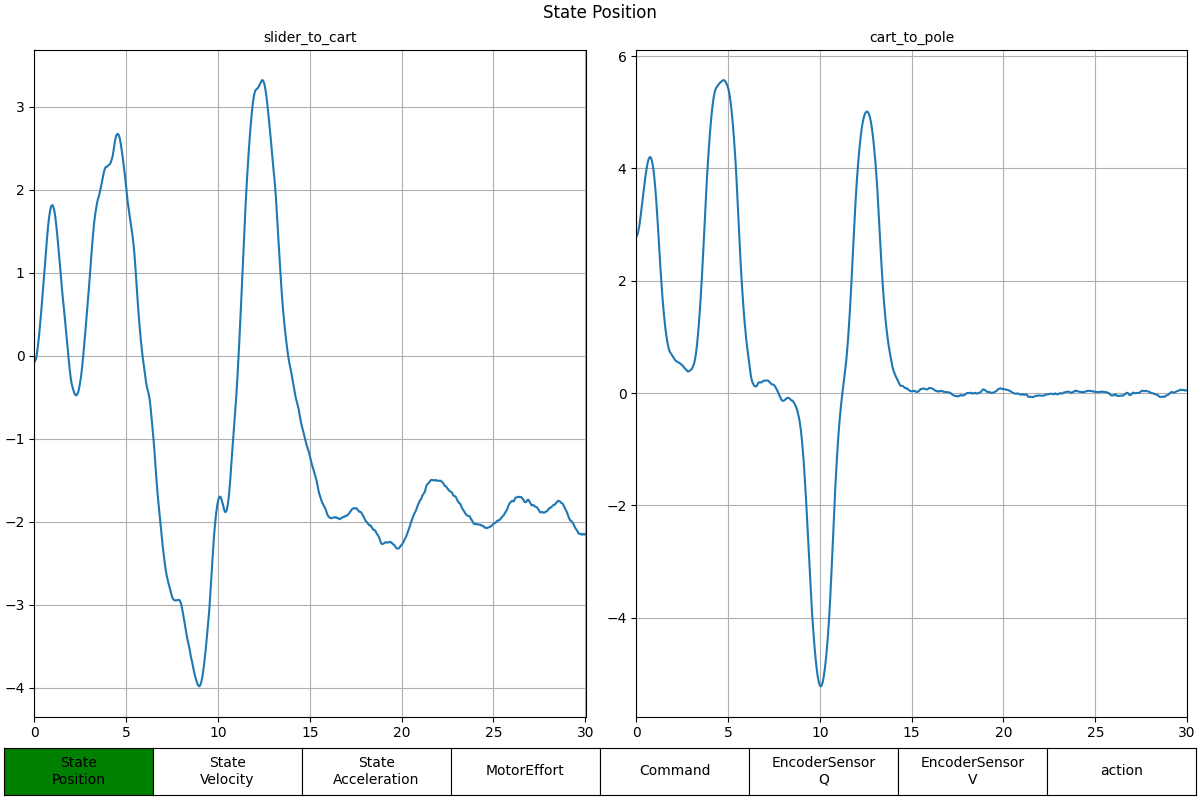

In [25]:
env.plot()